# **Transfer Learning and Fine-tuning**

Dalam tutorial ini, Anda akan mempelajari cara melakukan *image classification* ke dalam berbagai kategori dengan memanfaatkan *transfer learning* dari sebuah *pre-trained network*. Kita telah membahas beberapa model *pre-trained* dan arsitekturnya di bagian **"Common Pre-Trained Models"**. Sebagai pengingat, *pre-trained model* adalah jaringan yang sudah dilatih sebelumnya pada *dataset* yang sangat besar. *Transfer learning* memungkinkan kita menggunakan *feature* yang telah dipelajari tersebut, tanpa harus melatih model berukuran besar dari awal.

Di notebook ini, kita akan mempraktikkan salah satu dari dua strategi yang telah dibahas untuk menyesuaikan model *pre-trained*:

**Feature extraction**: Memanfaatkan representasi yang telah dipelajari oleh jaringan sebelumnya untuk mengekstraksi *feature* yang relevan dari sampel baru. Dengan *feature maps* yang dihasilkan oleh model *pre-trained* (misalnya pada *dataset* [**Imagenet**](https://www.image-net.org/)), kita cukup menambahkan *classifier* baru yang dapat dilatih di atas *feature maps* tersebut.

## Requirements

Sebelum memulai *notebook* ini, pastikan Anda telah memenuhi persyaratan berikut agar eksekusi kode dapat berjalan dengan efisien:

- **Lingkungan Google Colab dengan Akselerasi GPU**:  
  Untuk menjalankan kode ini dengan lebih cepat, pastikan Anda menggunakan lingkungan Google Colab dan mengaktifkan akselerasi GPU. Berikut langkah-langkahnya:
  1. Buka *notebook* ini di Google Colab ([Open in Colab](https://colab.research.google.com/)).
  2. Buka menu `Runtime` -> `Change runtime type` di bagian atas.
  3. Pilih `GPU` pada bagian `Hardware accelerator`.
  4. Klik `Save` untuk menerapkan perubahan.
  5. Sekarang Anda sudah dapat menjalankan setiap *cell* kode di *notebook* ini dengan dukungan akselerasi GPU.


## Set-up environment

Pertama, kita akan mengimpor pustaka yang kita perlukan, yaitu **torchvision** dan pustaka pendukung lainnya. Paket [**torchvision**](https://pytorch.org/vision/stable/index.html) mencakup beragam *dataset* populer, arsitektur model, serta transformasi gambar yang lazim digunakan pada bidang *computer vision*.

In [1]:
# General imports
import os # Untuk berinteraksi dengan sistem operasi, misalnya path, direktori, dsb.
import time # Untuk mengukur waktu eksekusi (profiling) atau membuat jeda (sleep).
import copy # Untuk menduplikasi objek (shallow / deep copy).
import numpy as np # Library untuk komputasi numerik, menyediakan array multidimensi dan berbagai fungsi matematika.
import collections # Menghadirkan struktur data tambahan seperti Counter, defaultdict, OrderedDict, dsb.

# Plotting imports
from PIL import Image # Untuk memuat dan memanipulasi berbagai format gambar.
import matplotlib.pyplot as plt # Library plotting 2D dasar; cocok untuk menampilkan grafik secara statis.
import plotly.graph_objects as go # Modulus graph objects untuk membuat plot interaktif dengan kontrol lebih detail.
from plotly.subplots import make_subplots # Memungkinkan membuat layout subplot yang kompleks secara interaktif.
import plotly.express as px # Library “express” untuk menghasilkan plot interaktif sederhana dan cepat.

# Torch imports
import torch # Kerangka kerja utama PyTorch untuk komputasi numerik berbasis tensor.
import torch.nn as nn # Submodul PyTorch yang berisi komponen-komponen neural network (layer, loss, dsb).
import torch.backends.cudnn as cudnn # Opsi backend CUDA (CUDNN) untuk performa tinggi pada GPU.
import torch.optim as optim # Submodul untuk optimizer (SGD, Adam, dsb).
from torch.optim.lr_scheduler import CosineAnnealingLR # Scheduler untuk mengatur laju pemelajaran (learning rate) secara bertahap menggunakan kurva cosinus.

# Torchvision imports
import torchvision # Paket yang menyediakan dataset, model, dan transformasi umum untuk visi komputer.
from torchvision import datasets, models # Berisi dataset vision populer (seperti CIFAR, ImageNet), serta model pra-terlatih (ResNet, VGG, dsb).
from torchvision.transforms import v2 # Modul baru untuk transformasi data (augmentasi, normalisasi, dsb) pada gambar versi 2.

plt.ion()

# selecting the available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data preprocessing

### Data download

Dalam tutorial ini, kita akan bekerja dengan **CIFAR10**, sebuah *dataset* terkenal yang berisi gambar dari 10 kelas berbeda. *CIFAR-10* terdiri atas 60.000 gambar berwarna dengan ukuran 32x32, masing-masing kelas memiliki 6.000 gambar. Tujuan utama kita adalah melatih model agar dapat melakukan klasifikasi pada gambar-gambar ini dengan akurat. Detail lebih lanjut mengenai *dataset* ini akan dibahas pada bagian selanjutnya.

**Catatan**: Anda dapat mengunduh data dari [**tautan ini**](https://www.cs.toronto.edu/~kriz/cifar.html). Data juga tersedia di 🤗 Hub, dan Anda dapat [**mengunduhnya**](https://huggingface.co/datasets/cifar10) dengan pustaka 🤗 Datasets. Kita akan menggunakan paket **torchvision** dan **torch.utils.data** untuk memuat data. Anda bisa mempelajari lebih lanjut tentang pemuatan gambar pada [**tutorial ini**](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).



### Data preparation and augmentation

Di sini, kita memfokuskan pada optimalisasi *dataset* untuk keperluan *training* dan *validation*. Untuk mencapainya, kita menggunakan [**transforms**](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#augmentation-transforms) dari PyTorch untuk menerapkan transformasi penting. Pada *training set*, kita memakai teknik [**resized transformation**](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#resize) dan [**Autoaugment transformation**](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#autoaugment) guna meningkatkan keragaman data, yang pada akhirnya membantu model melakukan *generalization* dengan lebih baik. Selain itu, kita juga menerapkan **normalization** pada nilai piksel, baik untuk *training set* maupun *validation set*, agar pemrosesan *neural network* berjalan lebih efisien. Proses persiapan data yang menyeluruh ini menjadi landasan kuat bagi pelatihan dan evaluasi model di tahap berikutnya.

**Catatan**: Normalisasi nilai piksel melibatkan penskalaan data agar memiliki *mean* (rata-rata) nol dan *variance* satu. Proses ini membantu menstabilkan pelatihan dan mempercepat konvergensi. Pilihan nilai *mean* dan *std* (standar deviasi) untuk normalisasi biasanya bergantung pada statistik *dataset* itu sendiri. Anda dapat membaca lebih lanjut mengenai pentingnya nilai *mean* dan *std* untuk normalisasi melalui [**diskusi di StackOverflow**](https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data).

In [2]:
# Classes in CIFAR-10 dataset (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
NUM_CLASSES = 10
# Image size for VGG19 (224x224)
IMAGE_SIZE = 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

# Data transformations for training set
train_transforms = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.AutoAugment(policy=v2.AutoAugmentPolicy.CIFAR10),
    v2.ToTensor(),
    v2.Normalize(mean, std)
])

# Data transformations for validation set
validation_transforms = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToTensor(),
    v2.Normalize(mean, std)
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
# Dataset for training objectives
train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transforms
)

# Dataset for validation objectives
validation_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=validation_transforms
)

100%|██████████| 170M/170M [00:02<00:00, 59.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Number of images in each dataset
print('Train dataset size:', len(train_set))
print('Validation dataset size:', len(validation_set))

Train dataset size: 50000
Validation dataset size: 10000


In [5]:
def plot_class_distribution(dataset, dataset_name):
    """
    Print and plot the class distribution of a dataset.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to analyze.
        dataset_name (str): The name of the dataset.

    Returns:
        None
    """
    # Extract labels from the dataset
    labels = [y for _, y in dataset]

    # Count the number of images per category
    counter = collections.Counter(labels)

    # Print class image counter
    print(f"Class Image Counter for {dataset_name} Data")
    print(counter, "\n")

    # Optionally, plot the class distribution
    plt.bar(counter.keys(), counter.values())
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution for {dataset_name} Data")
    plt.show()

Class Image Counter for Training Data
Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}) 



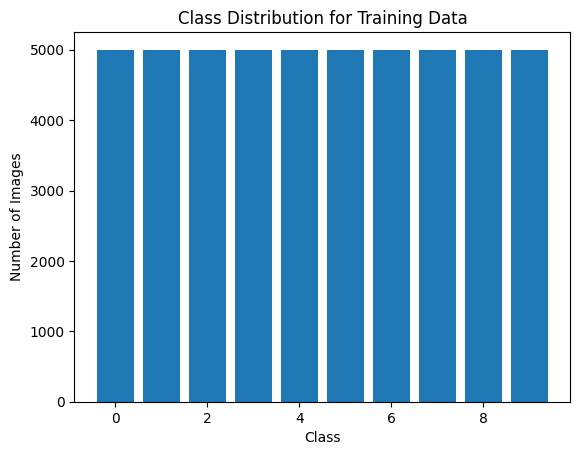

Class Image Counter for Validation Data
Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000}) 



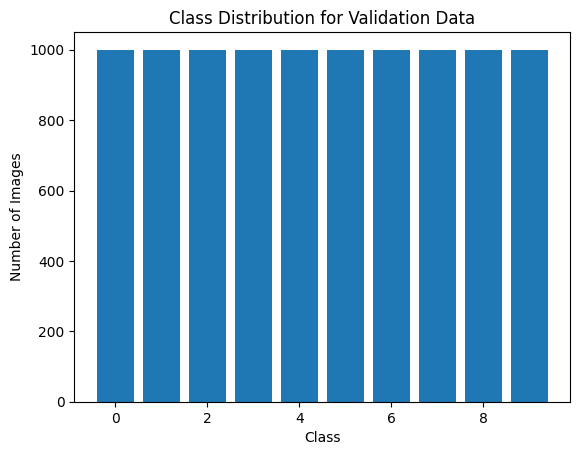

In [6]:
# Train dataset and test dataset (all classes) class distribution
plot_class_distribution(train_set, "Training")
plot_class_distribution(validation_set, "Validation")

Jadi, ada 10.000 *test samples* dan 50.000 *training samples* dalam *dataset* tersebut. Selain itu, setiap kelas pada *training dataset* memiliki 5.000 gambar, sementara setiap kelas pada *validation dataset* memiliki 1.000 gambar.

Akhirnya, saatnya menyiapkan *train loader* dan *validation loader* untuk proses pelatihan model kita. Ada dua istilah yang perlu dikenalkan dalam konteks ini, yaitu `batch_size` dan `num_gpus`:

- **Batch Size**: Menunjukkan jumlah sampel yang diproses setiap kali *forward/backward pass*. *Batch size* yang lebih besar bisa mempercepat konvergensi namun membutuhkan memori lebih besar dan dapat memicu masalah kinerja atau memori, terutama jika ukurannya terlalu besar.

- **Number of GPUs**: Menunjukkan banyaknya unit pemrosesan grafis (GPU) yang tersedia. Memanfaatkan beberapa GPU dapat mempercepat proses pelatihan, tetapi efektivitasnya bergantung pada berbagai faktor seperti arsitektur model, *batch size*, dan bagaimana distribusi data diatur.

In [7]:
# Define the batch size for processing samples per forward/backward pass
batch_size = 128

In [8]:
num_gpus = torch.cuda.device_count()

# DataLoader for training set
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2*num_gpus,
    pin_memory=True
)

# DataLoader for validation set
validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2*num_gpus,
    pin_memory=True
)

In [9]:
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


Dimensi *batch* gambar dinyatakan sebagai `torch.Size([128, 3, 224, 224])`, yang menunjukkan bahwa ada *batch* berisi 128 gambar, masing-masing memiliki 3 *color channels* (RGB), serta setiap gambar memiliki ukuran 224x224 piksel.

Dimensi label gambar dinyatakan sebagai `torch.Size([128])`, yang merujuk pada label yang bersesuaian dengan *batch* yang berisi 128 gambar tersebut. Setiap label direpresentasikan sebagai *tensor* satu dimensi.

**Catatan**: Pada awalnya, gambar-gambar dalam *dataset* memiliki ukuran 32x32. Namun, untuk dapat melatih model VGG19 secara efektif, kita perlu mengubah ukuran gambar menjadi 224x224—sesuai ukuran yang digunakan saat model VGG19 pertama kali dilatih. Oleh karena itu, kita menerapkan *resize transformation* pada gambar.

### Visualize a few images
Untuk lebih memahami *data augmentation*, mari kita visualisasikan beberapa gambar pada *training set*.

In [10]:
def imshow(tensor, title=None):
    """
    Display a batch of images in a grid.

    Args:
        tensor (torch.Tensor): The input tensor containing the images.
        title (str, optional): The title of the plot. Defaults to None.
    """
    image = torchvision.utils.make_grid(tensor).numpy().transpose((1, 2, 0))

    # Denormalize the image
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Increase the plot size
    plt.figure(figsize=(10, 10))

    # Plot the image
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

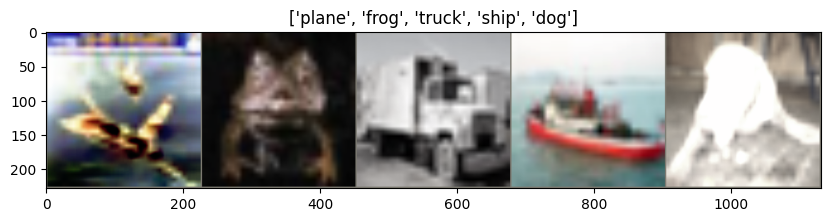

In [11]:
# Image classes in CIFAR-10 dataset
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

# Get a batch of training data
for inputs, labels in train_loader:
    # Display the first 8 images from the batch
    imshow(inputs[:5], title=[classes[x] for x in labels[:5]])

    break  # Break the loop after it finishes

## Model training

Bagian ini akan memperkenalkan fungsi pelatihan model kita, yang mencakup **learning rate scheduling** dan **model checkpointing**. Parameter *scheduler* bertugas mengoptimalkan *learning rate* untuk mempercepat konvergensi model. Sementara itu, *model checkpointing* memungkinkan penyimpanan model dengan performa terbaik, sehingga iterasi dengan hasil validasi paling optimal dapat dipertahankan. Fungsi pelatihan ini juga dilengkapi dengan fungsi pembantu seperti **metrics_batch** dan **loss_epoch**, yang secara keseluruhan membentuk alur pelatihan yang efisien.

### Helper functions

Berikut adalah penjelasan singkat mengenai beberapa *helper functions* yang akan membantu menangani perhitungan *loss* dan *learning rate* dalam proses *model training*:

1. **get_lr**  
   Fungsi ini mengambil *learning rate* saat ini dari *optimizer*. *Learning rate* merupakan *hyperparameter* yang mengatur seberapa besar langkah pembaruan parameter model pada setiap iterasi berdasarkan *gradient* dari *loss function*. Memantau nilai *learning rate* penting untuk memahami proses optimisasi serta membantu menyesuaikan skema *learning rate* demi kinerja pelatihan yang lebih baik.

2. **metrics_batch**  
   Fungsi ini menghitung jumlah prediksi yang benar di dalam satu *batch* dengan membandingkan hasil keluaran model dengan *target labels*-nya. Nilai tersebut menjadi metrik dasar untuk menilai performa model klasifikasi selama pelatihan (*training*) dan validasi. Memantau akurasi (atau metrik lain) di setiap *batch* memberikan gambaran seberapa akurat model dalam melakukan klasifikasi pada sampel-sampel yang ada.

3. **loss_batch**  
   Fungsi ini menghitung nilai *loss* untuk setiap *batch* data dengan menerapkan *loss function* tertentu pada keluaran model serta *target labels*. *Loss function* mengukur seberapa jauh perbedaan (error) antara nilai prediksi dengan nilai sebenarnya, sehingga menjadi indikator kinerja model pada *batch* tersebut. Jika fungsi ini menerima parameter *optimizer*, maka fungsi tersebut juga akan melakukan *backpropagation* serta langkah optimasi (pembaruan bobot model) berdasarkan *loss* yang sudah dihitung.

4. **loss_epoch**  
   Fungsi ini menghitung nilai rata-rata *loss* dan metrik performa (misal akurasi) untuk satu *epoch* penuh (baik untuk data pelatihan maupun validasi). Fungsi akan melakukan iterasi ke seluruh *batch* dalam *data loader*, menghitung *loss* serta metrik untuk masing-masing *batch*, lalu merata-ratakannya. Nilai yang diperoleh memberikan gambaran menyeluruh mengenai performa model pada *epoch* tersebut, membantu memantau perkembangan (progres) pelatihan serta menilai sejauh mana model efektif belajar dari *dataset*-nya.

In [12]:
# Set the learning rate for the optimizer
learning_rate = 1e-4

In [13]:
def get_lr(opt):
    """
    Helper function to get the current learning rate from the optimizer.

    Args:
        opt (Optimizer): The optimizer object.

    Returns:
        float: The current learning rate.
    """
    for param_group in opt.param_groups:
        return param_group["lr"]

In [14]:
def metrics_batch(output, target):
    """
    Helper function to count the number of correct predictions in a batch.

    Args:
        output (torch.Tensor): Model predictions.
        target (torch.Tensor): Target labels.

    Returns:
        int: Number of correct predictions.
    """
    # Get the predicted class for each example in the batch
    pred = output.argmax(dim=1, keepdim=True)
    # Compare predicted class with target class and count correct predictions
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


def loss_batch(loss_func, model_output, target, optimizer=None):
    """
    Helper function to compute the loss value per batch of data.

    Args:
        loss_func: Loss function.
        model_output (torch.Tensor): Model predictions.
        target (torch.Tensor): Target labels.
        optimizer: Optimizer for backpropagation (optional).

    Returns:
        tuple: Loss value, number of correct predictions.
    """
    # Calculate the loss using the specified loss function
    loss_value = loss_func(model_output, target)

    # Get performance metric (number of correct predictions)
    metric_batch = metrics_batch(model_output, target)

    if optimizer is not None:
        # Backpropagation and optimization step
        optimizer.zero_grad()
        #loss_value.requires_grad = True
        loss_value.backward()
        optimizer.step()

    return loss_value.item(), metric_batch


def loss_epoch(model, loss_func, data_loader, check_id=False, optimizer=None):
    """
    Compute the average loss value and performance metric over an epoch.

    Args:
        model: The neural network model.
        loss_func: Loss function.
        data_loader: DataLoader for the dataset.
        check_id (bool): Flag to check only the first batch.
        optimizer: Optimizer for backpropagation (optional).

    Returns:
        tuple: Average loss value, average performance metric.
    """
    running_loss = 0.0
    running_metric = 0.0
    total_samples = len(data_loader.dataset)

    # Internal loop over batches in the DataLoader
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_output = model(inputs)
        # Calculate loss and performance metric for the batch
        loss_batch_value, metric_batch_value = loss_batch(
            loss_func, model_output, labels, optimizer
        )
        running_loss += loss_batch_value

        if metric_batch_value is not None:
            running_metric += metric_batch_value

        if check_id:
            break  # Stop if only checking the first batch

    # Compute the average loss and performance metric over the entire epoch
    average_loss = running_loss / float(total_samples)
    average_metric = (
        running_metric / float(total_samples) if total_samples > 0 else None
    )

    return average_loss, average_metric

### Training loop

Fungsi yang digunakan untuk menjalankan *training loop* model kita.

In [15]:
def train_val(model, params, verbose=False):
    """
    Trains and validates a model using the given parameters.

    Args:
        model (torch.nn.Module): The model to be trained and validated.
        params (dict): A dictionary containing the parameters for training and validation.
            - epochs (int): The number of epochs to train the model.
            - loss_func (torch.nn.Module): The loss function to be used.
            - optimiser (torch.optim.Optimizer): The optimizer to be used for training.
            - train_dl (torch.utils.data.DataLoader): The data loader for the training dataset.
            - val_dl (torch.utils.data.DataLoader): The data loader for the validation dataset.
            - check_id (int): The ID for checking the loss and metric.
            - lr_scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
            - path (str): The path to save the best model weights.

        verbose (bool, optional): Whether to print additional information during training. Defaults to False.

    Returns:
        tuple: A tuple containing the trained model, loss history, and metric history.
            - model (torch.nn.Module): The trained model.
            - loss_history (dict): A dictionary containing the loss values for each epoch.
            - metric_history (dict): A dictionary containing the metric values for each epoch.
    """

    # extract model parameters
    epochs = params["epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    check_id = params["check_id"]
    lr_scheduler = params["lr_scheduler"]
    path = params["path"]

    loss_history = {"train": [], "val": []}  # history of loss values in each epoch
    metric_history = {"train": [], "val": []}  # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict())  # copy weights for best model
    best_loss = float("inf")  # initialize best loss to a large value

    # main loop
    for epoch in range(epochs):
        current_lr = get_lr(opt)  # get current learning rate
        if verbose:
            print(f"Epoch {epoch}/{epochs-1}, current lr={current_lr}")

        # train model on training dataset
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, check_id, opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, check_id)

        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), path)
            if verbose:
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step()

        if verbose:
            print(
                f"train loss: {train_loss:.6f}, train accuracy: {100*train_metric:.2f}, validation loss: {val_loss:.6f}, validation accuracy: {100*val_metric:.2f}"
            )
            print("")

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

### Display the model's metrics

Fungsi umum untuk menampilkan metrik model yang telah dilatih dengan transfer learning, seperti *loss* dan *akurasi*.

In [16]:
def plot_out(loss_hist, metric_hist, epochs=None):
    """
    Plot training and validation loss, and training and validation metrics over epochs.

    Args:
        loss_hist (dict): Dictionary containing 'train' and 'val' keys for loss history.
        metric_hist (dict): Dictionary containing 'train' and 'val' keys for metric history.
        epochs (int): Number of epochs.
    """

    # Create subplot with two columns
    fig = make_subplots(
        rows=1, cols=2, subplot_titles=["Model Loss", "Model Accuracy"]
    )

    # Plot Loss History
    for phase, color in zip(["train", "val"], ["#F1C40F", "#232323"]):
        fig.add_trace(
            go.Scatter(
                x=list(range(1, epochs + 1)),
                y=loss_hist[phase],
                name=phase,
                mode="lines",
                line_color=color,
            ),
            row=1,
            col=1,
        )

    # Plot Metric History
    for phase, color in zip(["train", "val"], ["#F1C40F", "#232323"]):
        fig.add_trace(
            go.Scatter(
                x=list(range(1, epochs + 1)),
                y=metric_hist[phase],
                name=phase,
                mode="lines",
                line_color=color,
            ),
            row=1,
            col=2,
        )

    # Update layout and display the plot
    fig.update_layout(
        template="plotly_white",
        showlegend=False,
        title="Loss & Accuracy History",
        height=400,
    )
    fig.update_layout(yaxis2=dict(range=[0.4, 1]))
    fig.show()

## Create the base model from the pre-trained convnets

Kita akan mulai membangun model yang dapat membedakan antara berbagai kelas dalam dataset CIFAR10. Untuk mencapai hal ini, kita akan memanfaatkan model **VGG19** sebagai dasar. [**VGG19**](https://arxiv.org/abs/1409.1556v6) adalah jaringan saraf konvolusional yang dalam yang telah dilatih sebelumnya pada dataset ImageNet. Dataset ImageNet terdiri dari lebih dari 1,4 juta gambar, yang dikategorikan ke dalam 1.000 kelas yang berbeda. VGG19 berfungsi sebagai *feature extractor* yang sangat baik untuk klasifikasi gambar dengan memanfaatkan pengetahuan dan fitur yang dipelajari dari ImageNet.

Untuk memulai, kita akan memuat model [**VGG19**](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html#torchvision.models.vgg19) beserta bobot pra-latihannya dari ImageNet.

**Catatan:** Sekarang, Anda dapat mempelajari lebih lanjut tentang model-model seperti ini beserta kode-kodenya di bagian **"Common Pre-Trained Models"**.

In [17]:
# Create the base model from the pre-trained model VGG19
pre_vgg19 = models.vgg19(weights='IMAGENET1K_V1')
pre_vgg19

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 80.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Feature extraction
Pada langkah ini, kita akan **membekukan** *convolutional base* yang dibuat dari langkah sebelumnya dan menggunakannya sebagai *feature extractor*. Selain itu, kita menambahkan *classifier* di atasnya dan melatih *classifier* tingkat atas.

In [18]:
# change the number of classes
pre_vgg19.classifier[6].out_features = NUM_CLASSES

# freeze convolution weights
for param in pre_vgg19.features.parameters():
    param.requires_grad = False

### Train and evaluate

Jalankan proses pelatihan model dan evaluasi performanya pada set validasi.

In [19]:
# Send earlier defined model to device
device = torch.device("cuda:0")
pre_vgg19 = pre_vgg19.to(device)

# Loss function, optimizer, LR scheduler
loss_func = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(pre_vgg19.parameters(), lr=learning_rate)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

# Set Training Parameters
training_params = {
    "epochs": 10,
    "optimizer": optimizer,
    "loss_func": loss_func,
    "train_dl": train_loader,
    "val_dl": validation_loader,
    "check_id": False,
    "lr_scheduler": lr_scheduler,
    "path": "pre_vgg19.pt",
}

# Train and validate the model
pre_vgg19, loss_history, metric_history = train_val(
    pre_vgg19, training_params, verbose=False
)

### Learning curves

Plot dan analisis loss pelatihan dan validasi serta akurasi selama beberapa epoch.

In [20]:
# Plot History
plot_out(loss_history, metric_history, epochs=training_params["epochs"])

![transferlearning_vgg19_plot.png](attachment:transferlearning_vgg19_plot.png)

Seperti yang ditunjukkan oleh grafik di atas, loss pelatihan dan validasi menurun seiring bertambahnya epoch, sementara akurasi pelatihan dan validasi meningkat. Ini menunjukkan bahwa model kita sedang mempelajari fitur-fitur dari gambar dan dapat mengklasifikasikannya ke dalam kelas yang benar. Dengan menggunakan **vgg19** sebagai model dasar, kita telah mencapai **akurasi sebesar 88,66%** pada **set validasi**. Itu semua hanya dengan **10 epoch** pelatihan! Inilah kekuatan transfer learning.

## Inference on custom images

Buat prediksi pada gambar kustom menggunakan model yang telah dilatih, dan tampilkan label kelas yang diprediksi di sebelah gambar.

In [21]:
def visualize_model_predictions(model, img_path):
    """
    Visualizes model predictions on a single image.

    Args:
        model (torch.nn.Module): The trained model.
        img_path (str): Path to the input image.

    Returns:
        None
    """
    # Set the model to evaluation mode
    was_training = model.training
    model.eval()

    # Load and preprocess the input image
    img = Image.open(img_path)
    img = validation_transforms(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    # Perform forward pass to obtain predictions
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        # Display the input image and predicted class
        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {classes[preds[0]]}")
        imshow(img.cpu().data[0])

    # Set the model back to its original training mode
    model.train(mode=was_training)

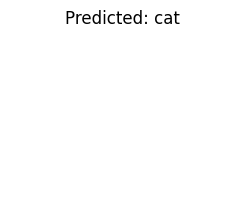

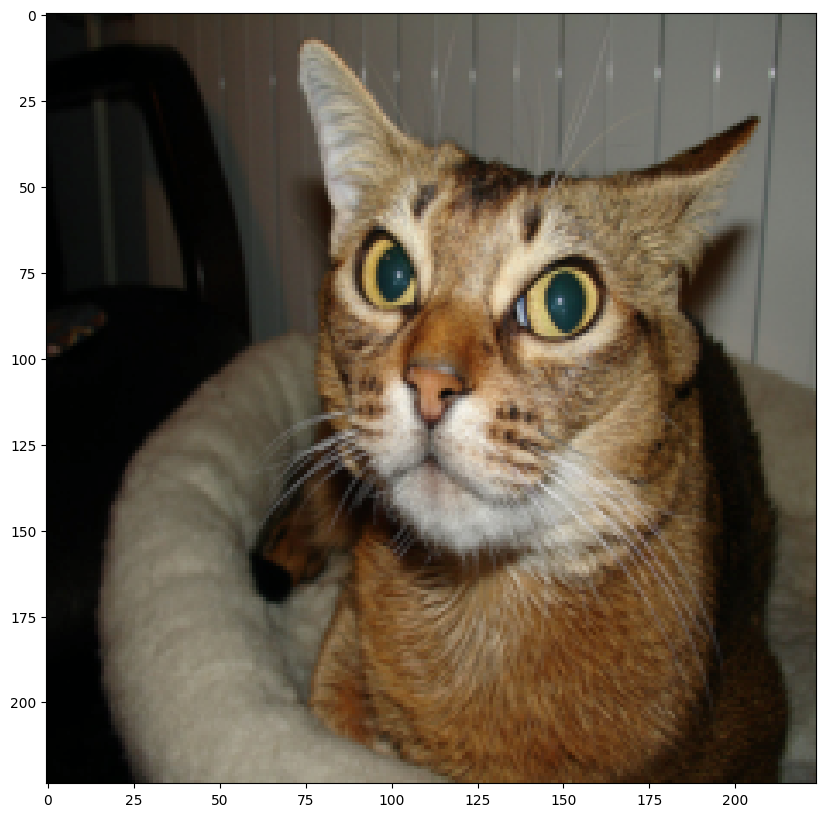

In [25]:
# Visualize model predictions
visualize_model_predictions(pre_vgg19, img_path="/content/00000001_020.jpg")

plt.ioff()
plt.show()

## Summary

Ketika bekerja dengan *dataset* yang kecil, praktik umum adalah memanfaatkan *feature* yang telah dipelajari oleh model yang dilatih pada *dataset* yang lebih besar dalam domain yang sama. Hal ini dilakukan dengan menginisialisasi model *pre-trained* dan menambahkan *classifier* yang sepenuhnya terhubung (*fully connected*) di atasnya. Model *pre-trained* ini "dibekukan," yang berarti hanya bobot *classifier* yang diperbarui selama pelatihan.

Di sini, *convolutional base* mengekstrak setiap *feature* yang terhubung dengan setiap gambar, dan kita hanya melatih *classifier* untuk mengidentifikasi kelas gambar berdasarkan kumpulan *feature* yang telah diekstraksi tersebut.